In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from datetime import datetime

today = datetime.today()
today = today.strftime("%m-%d-%Y")

plt.style.use('[YOUR_DIRECTORY_HERE]/panoptic-dark-16_9.mplstyle')

In [2]:
dir = "[YOUR_DIRECTORY_TO_SAVE_TO_HERE]/"

In [3]:
query_initial = gql("""
    query GetPositionSnapshots($lastID: String) {
        positionSnapshots(first: 1, orderBy: position__leverage, orderDirection: desc) {
            id
            timestamp
            position {
                timestampOpened
                timestampClosed
                asset {
                    id
                }
                realisedPnlUSD
                side
                leverage
            }
        }
    }
""")

query = gql("""
    query GetPositionSnapshots($lastID: String) {
        positionSnapshots(first: 1000, where: { id_gt: $lastID }, orderBy: position__leverage, orderDirection: desc) {
            id
            timestamp
            position {
                timestampOpened
                timestampClosed
                asset {
                    id
                }
                asset
                balanceUSD
                collateralBalanceUSD
                realisedPnlUSD
                side
                leverage
            }
        }
    }
""")

In [4]:
# Connects to the Messari GMX Arbitrum subgraph
client = Client(
 transport=RequestsHTTPTransport(
 url='https://api.thegraph.com/subgraphs/name/messari/gmx-arbitrum',
 verify=True,
 retries=5,
 ))


all_results = []
last_id = None
while True:
    if last_id is None:
        my_query = query_initial
    else:
        my_query = query

    params = {"lastID": last_id}
    try:
        result = client.execute(my_query, variable_values=params)
        # print(result)
    except Exception as ex:
        print("got exception while querying data:", ex)
        raise BaseException("Exception while querying data:", ex)

    # check if there are no more results
    if not result["positionSnapshots"]:
        break

    all_results.extend(result["positionSnapshots"])
    last_id = result["positionSnapshots"][-1]["id"]

In [5]:
# Number of open and closed positions
len(all_results)

331496

In [6]:
# Convert data to pandas dataframe
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Flatten dictionaries in the list
all_results_flat = [flatten_dict(item) for item in all_results]

df = pd.DataFrame(all_results_flat)
df

,id,timestamp,position_timestampOpened,position_timestampClosed,position_asset_id,position_realisedPnlUSD,position_side,position_leverage,position_balanceUSD,position_collateralBalanceUSD
0,0x61e45e9a3f11b54762f1f9198af7834ea0ba5ab2489e...,1686061823,1686061823,None,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,None,LONG,66.65743595978941189321392515518678,NaN,NaN
1,0xafd44320bf0bd23a572ee2b2deba238546606089489e...,1686073179,1686073179,None,0x2f2a2543b76a4166549f7aab2e75bef0aefc5b0f,None,SHORT,54.9252977091090116565447306829469,97548.99662252452007072616984878504,1776.030366538125086203273830151214
2,0x8787e15b3bd497ca6008a0bad0a5c9706cb4eeed489e...,1685983115,1681433413,None,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,None,SHORT,50.90630658816301109478584876665783,14397.80218643841800094438852955,282.829440032215319755168653022479
3,0x8787e15b3bd497ca6008a0bad0a5c9706cb4eeed489e...,1683813535,1681433413,None,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,None,SHORT,50.90630658816301109478584876665783,14397.80218643841800094438852955,282.829440032215319755168653022479
4,0x8787e15b3bd497ca6008a0bad0a5c9706cb4eeed489e...,1683206752,1681433413,None,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,None,SHORT,50.90630658816301109478584876665783,14397.80218643841800094438852955,282.829440032215319755168653022479
...,...,...,...,...,...,...,...,...,...,...
331491,0xffffbdea9371fef6f43c9fa89fa172e58eec7e8d489e...,1667030381,1667030381,1667030675,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,0.00912369532339846066611344063,LONG,0,0,0
331492,0xffffbdea9371fef6f43c9fa89fa172e58eec7e8d489e...,1667030359,1667030338,1667030359,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,0.041087036621727552865605135628,LONG,0,0,0
331493,0xffffbdea9371fef6f43c9fa89fa172e58eec7e8d489e...,1667030675,1667030381,1667030675,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,0.00912369532339846066611344063,LONG,0,0,0
331494,0xffffbdea9371fef6f43c9fa89fa172e58eec7e8d489e...,1667030381,1667030381,1667030675,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,0.00912369532339846066611344063,LONG,0,0,0


In [7]:
# Save data as .csv file
df.to_csv(f"{dir}snapshot.csv")

In [8]:
for col in ['position_realisedPnlUSD', 'position_leverage', 'position_balanceUSD', 'position_collateralBalanceUSD']:
    df[col] = df[col].astype(float)

6275


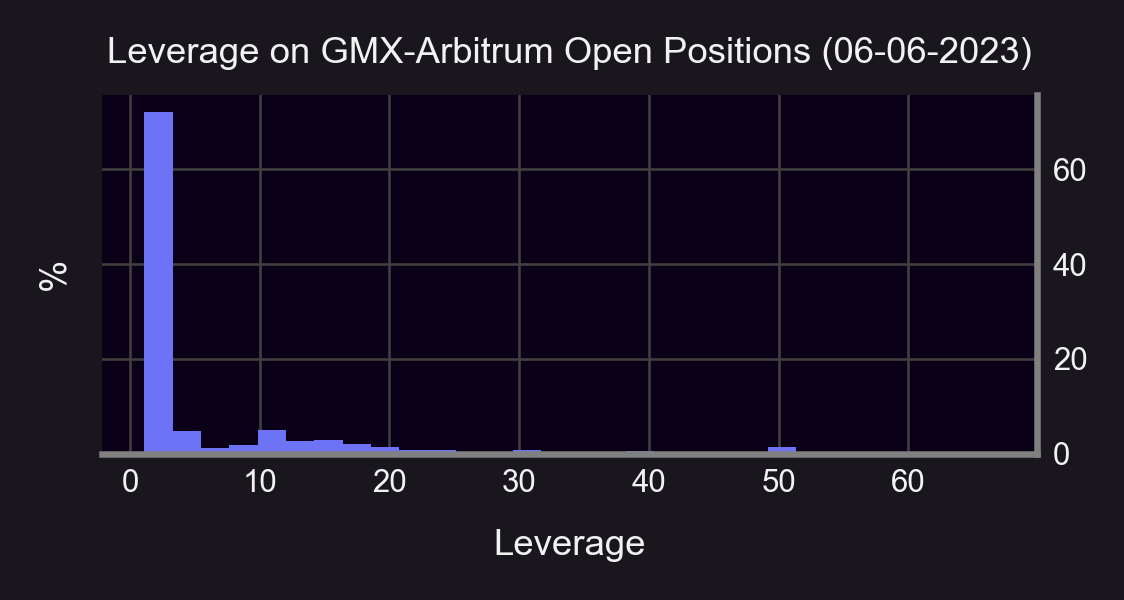

In [9]:
open_trades = df[df['position_timestampClosed'].isnull()]
print(len(open_trades))

weights = (np.ones_like(open_trades['position_leverage']) / len(open_trades['position_leverage'])) * 100
counts, bins, patches = plt.hist(open_trades['position_leverage'], bins=30, weights=weights)

plt.ylabel('%')
plt.xlabel('Leverage')
plt.title(f'Leverage on GMX-Arbitrum Open Positions ({today})')
plt.savefig(f'{dir}leverage-gmx-arbitrum-{today}', dpi=750)
plt.show()

In [10]:
# Number of open positions
len(open_trades)

6275

5249


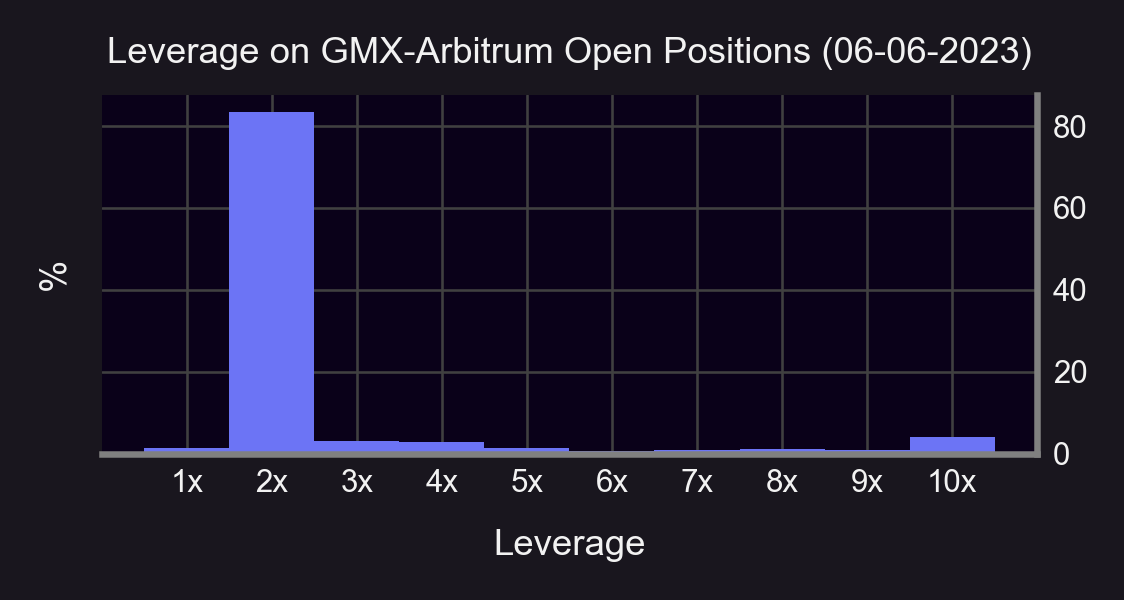

In [11]:
open_trades = df[(df['position_timestampClosed'].isnull()) & (df.position_leverage <= 11)]
print(len(open_trades))

bin_edges = range(1, 12)
weights = (np.ones_like(open_trades['position_leverage']) / len(open_trades['position_leverage'])) * 100
counts, bins, patches = plt.hist(open_trades['position_leverage'], bins=bin_edges, weights=weights)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.xticks(bin_centers, labels=[f"{b:.0f}x" for b in bins[:10]], rotation=0)
plt.ylabel('%')
plt.xlabel('Leverage')
plt.title(f'Leverage on GMX-Arbitrum Open Positions ({today})')
plt.savefig(f'{dir}leverage-gmx-arbitrum-{today}_zoom.png', dpi=750)
plt.show()

In [12]:
# Number of open positions with 11x leverage or less
len(open_trades)

5249

In [13]:
bin_edges = range(1, 12)
open_trades['leverage_bin'] = pd.cut(df['position_leverage'], bins)
median_col_sizes = open_trades.groupby(['leverage_bin'])['position_collateralBalanceUSD'].median()

C:\Users\lybra\AppData\Local\Temp\ipykernel_40596\886790661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_trades['leverage_bin'] = pd.cut(df['position_leverage'], bins)


In [14]:
median_col_sizes.index = median_col_sizes.index.astype(str).str.replace(r'\((\d+), (\d+)\]', r'\1x', regex=True)
median_col_sizes = median_col_sizes.round(0).astype(int)
median_col_sizes = median_col_sizes.apply(lambda x: f'${x:,}')
median_col_sizes

leverage_bin
1x         $11
2x        $480
3x      $1,104
4x     $13,876
5x        $137
6x        $269
7x        $379
8x      $1,493
9x        $527
10x       $518
Name: position_collateralBalanceUSD, dtype: object

5249


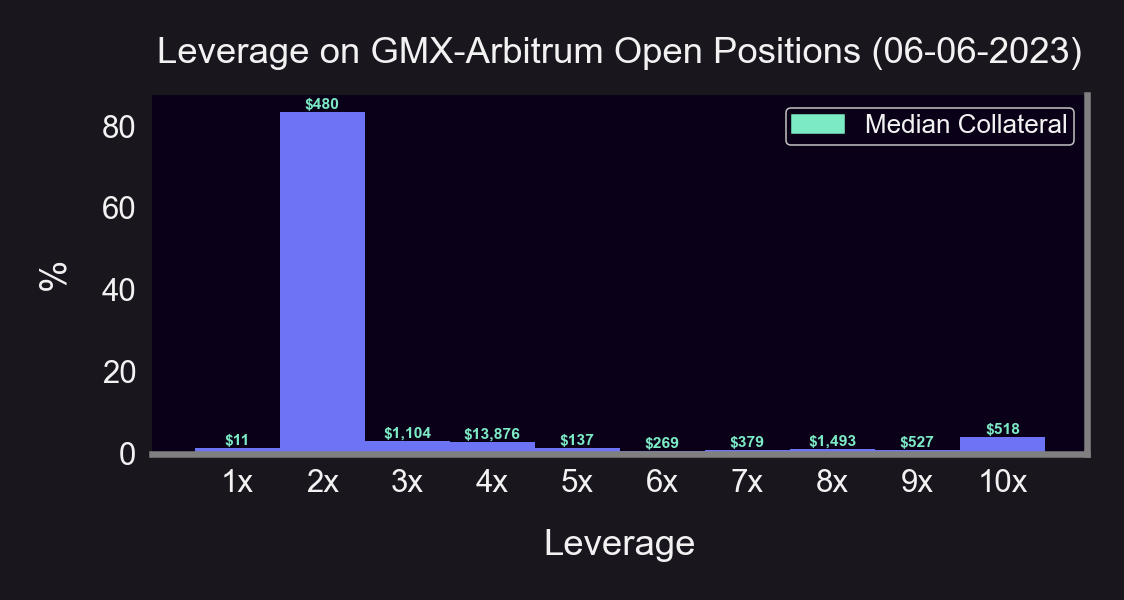

In [15]:
open_trades = df[(df['position_timestampClosed'].isnull()) & (df.position_leverage <= 11)]
print(len(open_trades))

bin_edges = range(1, 12)
weights = (np.ones_like(open_trades['position_leverage']) / len(open_trades['position_leverage'])) * 100
counts, bins, patches = plt.hist(open_trades['position_leverage'], bins=bin_edges, weights=weights)
bin_centers = (bins[:-1] + bins[1:]) / 2

ax = plt.gca()
ax.yaxis.tick_left()
ax.grid(False)

color = '#7ceac5'
for i, value in enumerate(counts):
    plt.text(bin_centers[i], value, median_col_sizes[i], ha='center', va='bottom', fontsize=3, weight='bold', color=color)
median_patch = mpatches.Patch(color=color, label='Median Collateral')
ax.legend(handles=[median_patch])

plt.xticks(bin_centers, labels=[f"{b:.0f}x" for b in bins[:10]], rotation=0)
plt.ylabel('%')
plt.xlabel('Leverage')
plt.title(f'Leverage on GMX-Arbitrum Open Positions ({today})')
plt.savefig(f'{dir}leverage-gmx-arbitrum-{today}_zoom_col_med.png', dpi=750)
plt.show()

In [18]:
open_trades = df[(df['position_timestampClosed'].isnull()) & (df.position_leverage <= 21)]
print(len(open_trades))

bin_edges = range(1, 22)
open_trades['leverage_bin'] = pd.cut(df['position_leverage'], bins)
median_col_sizes = open_trades.groupby(['leverage_bin'])['position_collateralBalanceUSD'].median()

median_col_sizes.index = median_col_sizes.index.astype(str).str.replace(r'\((\d+), (\d+)\]', r'\1x', regex=True)
median_col_sizes = median_col_sizes.round(0).astype(int)
median_col_sizes = median_col_sizes.apply(lambda x: f'${x:,}')
median_col_sizes

5929


C:\Users\lybra\AppData\Local\Temp\ipykernel_40596\549110881.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_trades['leverage_bin'] = pd.cut(df['position_leverage'], bins)


leverage_bin
1x         $11
2x        $480
3x      $1,104
4x     $13,876
5x        $137
6x        $269
7x        $379
8x      $1,493
9x        $527
10x       $518
11x       $241
12x       $562
13x       $491
14x     $1,056
15x       $330
16x       $945
17x     $1,277
18x     $5,682
19x       $646
20x       $936
Name: position_collateralBalanceUSD, dtype: object

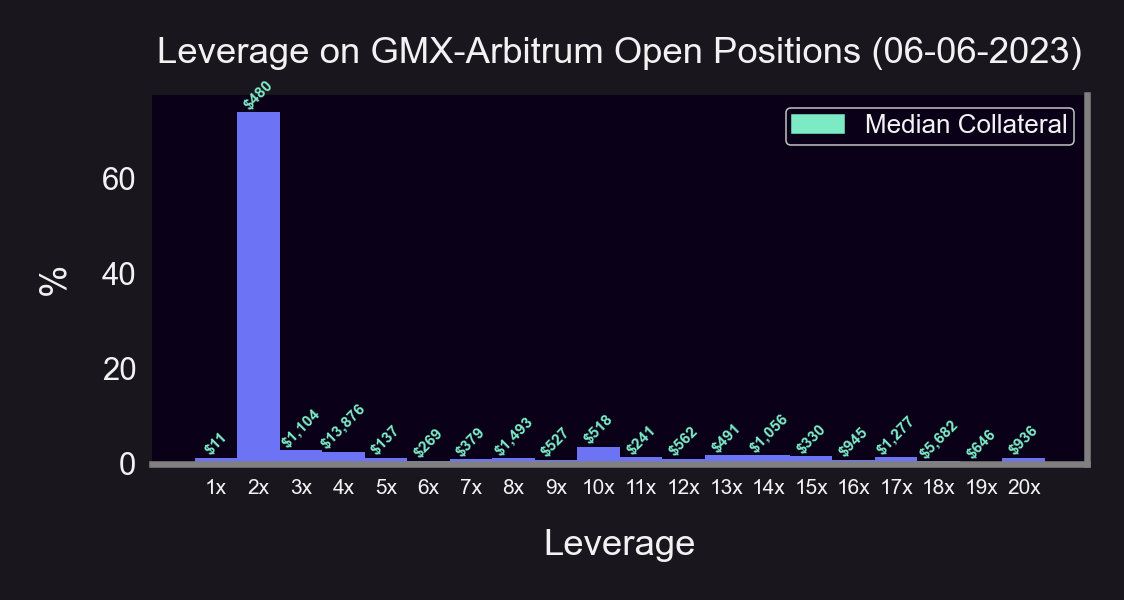

In [23]:
weights = (np.ones_like(open_trades['position_leverage']) / len(open_trades['position_leverage'])) * 100
counts, bins, patches = plt.hist(open_trades['position_leverage'], bins=bin_edges, weights=weights)
bin_centers = (bins[:-1] + bins[1:]) / 2

ax = plt.gca()
ax.yaxis.tick_left()
ax.grid(False)

color = '#7ceac5'
for i, value in enumerate(counts):
    plt.text(bin_centers[i], value, median_col_sizes[i], ha='center', va='bottom', fontsize=3, weight='bold', color=color, rotation=45)
median_patch = mpatches.Patch(color=color, label='Median Collateral')
ax.legend(handles=[median_patch])

plt.xticks(bin_centers, labels=[f"{b:.0f}x" for b in bins[:20]], rotation=0, fontsize=4)
plt.ylabel('%')
plt.xlabel('Leverage')
plt.title(f'Leverage on GMX-Arbitrum Open Positions ({today})')
plt.savefig(f'{dir}leverage-gmx-arbitrum-{today}_zoom_20x_col_med.png', dpi=750)
plt.show()

In [24]:
len(df[df['position_timestampClosed'].isnull()])

6275

In [25]:
temp = df[(df['position_timestampClosed'].isnull()) & (df.position_leverage >= 10)]
len(temp)

1237

In [27]:
# Proportion of open positions with 10x or higher leverage
1237/6275

0.19713147410358567